In [1]:
import sys
import parse_PAGE
import cv2
import line_extraction
import numpy as np
import os
import traceback
from collections import defaultdict
from scipy import ndimage
import json
import codecs
from svgpathtools import Path, Line
from scipy.interpolate import griddata
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.patches as patches

HT = 60

In [2]:
def generate_offset_mapping(img, ts, path, offset_1, offset_2, max_min = None, cube_size = None):
    # cube_size = 80

    offset_1_pts = []
    offset_2_pts = []
    # for t in ts:
    for i in range(len(ts)):
        t = ts[i]
        pt = path.point(t)

        norm = None
        if i == 0:
            norm = normal(pt, path.point(ts[i+1]))
            norm = norm / dis(complex(0,0), norm)
        elif i == len(ts)-1:
            norm = normal(path.point(ts[i-1]), pt)
            norm = norm / dis(complex(0,0), norm)
        else:
            norm1 = normal(path.point(ts[i-1]), pt)
            norm1 = norm1 / dis(complex(0,0), norm1)
            norm2 = normal(pt, path.point(ts[i+1]))
            norm2 = norm2 / dis(complex(0,0), norm2)

            norm = (norm1 + norm2)/2
            norm = norm / dis(complex(0,0), norm)

        offset_vector1 = offset_1 * norm
        offset_vector2 = offset_2 * norm

        pt1 = pt + offset_vector1
        pt2 = pt + offset_vector2

        offset_1_pts.append(complexToNpPt(pt1))
        offset_2_pts.append(complexToNpPt(pt2))

    offset_1_pts = np.array(offset_1_pts)
    offset_2_pts = np.array(offset_2_pts)

    h,w = img.shape[:2]

    offset_source2 = np.array([(cube_size*i, 0) for i in range(len(offset_1_pts))], dtype=np.float32)
    offset_source1 = np.array([(cube_size*i, cube_size) for i in range(len(offset_2_pts))], dtype=np.float32)

    offset_source1 = offset_source1[::-1]
    offset_source2 = offset_source2[::-1]

    source = np.concatenate([offset_source1, offset_source2])
    destination = np.concatenate([offset_1_pts, offset_2_pts])

    source = source[:,::-1]
    destination = destination[:,::-1]

    n_w = int(offset_source2[:,0].max())
    n_h = int(cube_size)

    grid_x, grid_y = np.mgrid[0:n_h, 0:n_w]

    grid_z = griddata(source, destination, (grid_x, grid_y), method='cubic')
    map_x = np.append([], [ar[:,1] for ar in grid_z]).reshape(n_h,n_w)
    map_y = np.append([], [ar[:,0] for ar in grid_z]).reshape(n_h,n_w)
    map_x_32 = map_x.astype('float32')
    map_y_32 = map_y.astype('float32')

    rectified_to_warped_x = map_x_32
    rectified_to_warped_y = map_y_32

    grid_x, grid_y = np.mgrid[0:h, 0:w]
    grid_z = griddata(source, destination, (grid_x, grid_y), method='cubic')
    map_x = np.append([], [ar[:,1] for ar in grid_z]).reshape(h,w)
    map_y = np.append([], [ar[:,0] for ar in grid_z]).reshape(h,w)
    map_x_32 = map_x.astype('float32')
    map_y_32 = map_y.astype('float32')

    warped_to_rectified_x = map_x_32
    warped_to_rectified_y = map_y_32

    return rectified_to_warped_x, rectified_to_warped_y, warped_to_rectified_x, warped_to_rectified_y, max_min


def dis(pt1, pt2):
    a = (pt1.real - pt2.real)**2
    b = (pt1.imag - pt2.imag)**2
    return np.sqrt(a+b)

def complexToNpPt(pt):
    return np.array([pt.real, pt.imag], dtype=np.float32)

def normal(pt1, pt2):
    dif = pt1 - pt2
    return complex(-dif.imag, dif.real)

def find_t_spacing(path, cube_size):

    l = path.length()
    error = 0.01
    init_step_size = cube_size / l

    last_t = 0
    cur_t = 0
    pts = []
    ts = [0]
    pts.append(complexToNpPt(path.point(cur_t)))
    path_lookup = {}
    for target in np.arange(cube_size, int(l), cube_size):
        step_size = init_step_size
        for i in range(1000):
            cur_length = dis(path.point(last_t), path.point(cur_t))
            if np.abs(cur_length - cube_size) < error:
                break

            step_t = min(cur_t + step_size, 1.0)
            step_l = dis(path.point(last_t), path.point(step_t))

            if np.abs(step_l - cube_size) < np.abs(cur_length - cube_size):
                cur_t = step_t
                continue

            step_t = max(cur_t - step_size, 0.0)
            step_t = max(step_t, last_t)
            step_t = max(step_t, 1.0)

            step_l = dis(path.point(last_t), path.point(step_t))

            if np.abs(step_l - cube_size) < np.abs(cur_length - cube_size):
                cur_t = step_t
                continue

            step_size = step_size / 2.0

        last_t = cur_t

        ts.append(cur_t)
        pts.append(complexToNpPt(path.point(cur_t)))

    pts = np.array(pts)

    return ts



In [3]:
def get_basename(img_name):
    head, tail = os.path.split(img_name)
    basename = 'base_' + tail
    basename = basename[:-4]
    return basename

def handle_single_para(para_df, output_directory, flip=False):
    
    output_data = []
    num_lines = len(para_df)
    print('....', num_lines)
    if os.path.exists(para_df.image_file.iloc[0]):
        img = cv2.imread(para_df.image_file.iloc[0])
        if flip:
            img = cv2.flip(img, 1)
    else:
        print('....File not found', para_df.image_file.iloc[0])
        return ''
    basename = get_basename(para_df.image_file.iloc[0])    
    
    all_lines = ""
    
    # get rid of png/jpg extension
    
    for region in [0]:
        region_output_data = []
        #print('in region', region)
        for ind, line in enumerate(para_df.line_number):
            if len(para_df.polygon_pts[ind]) == 0:
                print('No polygon pts in img', para_df.image_file.iloc[0][-15:],
                      'line number', line)
                continue
            #print('....ind, line', ind, line)
            line_mask = line_extraction.extract_region_mask(img, para_df.polygon_pts[ind])
            masked_img = img.copy()
            masked_img[line_mask==0] = 0

            summed_axis0 = (masked_img.astype(float) / 255).sum(axis=0)
            summed_axis1 = (masked_img.astype(float) / 255).sum(axis=1)

            non_zero_cnt0 = np.count_nonzero(summed_axis0) / float(len(summed_axis0))
            non_zero_cnt1 = np.count_nonzero(summed_axis1) / float(len(summed_axis1))

            avg_height0 = np.median(summed_axis0[summed_axis0 != 0])
            avg_height1 = np.median(summed_axis1[summed_axis1 != 0])

            avg_height = min(avg_height0, avg_height1)
            if non_zero_cnt0 > non_zero_cnt1:
                target_step_size = avg_height0
            else:
                target_step_size = avg_height1

            paths = []
            for i in range(len(para_df.baseline[ind])-1):
                i_1 = i+1

                p1 = para_df.baseline[ind][i]
                p2 = para_df.baseline[ind][i_1]

                p1_c = complex(*p1)
                p2_c = complex(*p2)


                paths.append(Line(p1_c, p2_c))


            if len(paths) == 0:
                print('Path length is 0', 'for ind', ind)
                continue
            # Add a bit on the end
            tan = paths[-1].unit_tangent(1.0)
            p3_c = p2_c + target_step_size * tan
            paths.append(Line(p2_c, p3_c))

            path = Path(*paths)
            
            try:
                ts = find_t_spacing(path, target_step_size)
                
                #Changing this causes issues in pretraining - not sure why
                target_height = HT

                rectified_to_warped_x, rectified_to_warped_y, warped_to_rectified_x, warped_to_rectified_y, max_min = generate_offset_mapping(masked_img, ts, path, 0, -2*target_step_size, cube_size = target_height)
                warped_above = cv2.remap(line_mask, rectified_to_warped_x, rectified_to_warped_y, cv2.INTER_CUBIC, borderValue=(0,0,0))

                rectified_to_warped_x, rectified_to_warped_y, warped_to_rectified_x, warped_to_rectified_y, max_min = generate_offset_mapping(masked_img, ts, path, 2*target_step_size, 0, cube_size = target_height)
                warped_below = cv2.remap(line_mask, rectified_to_warped_x, rectified_to_warped_y, cv2.INTER_CUBIC, borderValue=(0,0,0))

                above_scale =  np.max((warped_above.astype(float) / 255).sum(axis=0))
                below_scale = np.max((warped_below.astype(float) / 255).sum(axis=0))


                
                ab_sum = above_scale + below_scale
                above = target_step_size * (above_scale/ab_sum)
                below = target_step_size * (below_scale/ab_sum)

                above = target_step_size * (above_scale/(target_height/2.0))
                below = target_step_size * (below_scale/(target_height/2.0))
                target_step_size = above + below
                ts = find_t_spacing(path, target_step_size)
                if len(ts) <= 1:
                    print('Not doing line', line)
                    continue
                rectified_to_warped_x, rectified_to_warped_y, warped_to_rectified_x, warped_to_rectified_y, max_min = generate_offset_mapping(masked_img, ts, path, below, -above, cube_size=target_height)

                rectified_to_warped_x = rectified_to_warped_x[::-1,::-1]
                rectified_to_warped_y = rectified_to_warped_y[::-1,::-1]

                warped_to_rectified_x = warped_to_rectified_x[::-1,::-1]
                warped_to_rectified_y = warped_to_rectified_y[::-1,::-1]

                warped = cv2.remap(img, rectified_to_warped_x, rectified_to_warped_y, cv2.INTER_CUBIC, borderValue=(255,255,255))
            except:
                print('Not doing line', line)
                continue
            
            
            mapping = np.stack([rectified_to_warped_y, rectified_to_warped_x], axis=2)

            top_left = mapping[0,0,:] / np.array(img.shape[:2]).astype(np.float32)
            btm_right = mapping[min(mapping.shape[0]-1, target_height-1), min(mapping.shape[1]-1, target_height-1),:] / np.array(img.shape[:2]).astype(np.float32)


            line_points = []
            for i in range(0,mapping.shape[1],target_height):

                x0 = float(rectified_to_warped_x[0,i])
                x1 = float(rectified_to_warped_x[-1,i])

                y0 = float(rectified_to_warped_y[0,i])
                y1 = float(rectified_to_warped_y[-1,i])

                line_points.append({
                    "x0": x0, 
                    "x1": x1, 
                    "y0": y0, 
                    "y1": y1, 
                })
                
                
                                
            ###Mehreen add for viewing

#            plt.imshow(img) # or display line warped
#            print("****", line_points)
#            for coord in line_points:
#                x = coord["x0"]
#                y = coord["y0"]
#                x1 = coord["x1"]
#                y1 = coord["y1"]
                #rect = patches.Rectangle((x, y), np.abs(x-coord[2]), np.abs(y-coord[3]), facecolor='green')
#                rect = patches.Rectangle((x, y), 10, 10, facecolor='blue')
#                rect1 = patches.Rectangle((x1, y1), 10, 10, facecolor='red')
#                plt.gca().add_patch(rect)  
#                plt.gca().add_patch(rect1)
#            rect0 = patches.Rectangle((line_points[0]["x0"], line_points[0]["y0"]), 10, 10, facecolor='yellow') 
#            plt.gca().add_patch(rect0)
#            plt.show()
             ## ENd mehreen add for view   
                
            
            output_file = os.path.join(output_directory, 
                          basename, "{}~{}~{}.png".format(basename, region, line))
            warp_output_file = os.path.join(output_directory, basename, "{}-{}.png".format(basename, line))
            warp_output_file_save = os.path.join(basename, "{}-{}.png".format(basename, str(len(region_output_data))))
            save_file = os.path.join(basename, "{}~{}~{}.png".format(basename, region, line))
            region_output_data.append({
                "gt": para_df.ground_truth[ind],
                "image_path": save_file,
                "sol": line_points[0],
                "lf": line_points,
                "hw_path": warp_output_file #MEhreen commentwarp_output_file_save
            })
            #print('****', output_file)
            if not os.path.exists(os.path.dirname(output_file)):
                try:
                    os.makedirs(os.path.dirname(output_file))
                except OSError as exc:
                    raise Exception("Could not write file")

            cv2.imwrite(warp_output_file, warped)

        output_data.extend(region_output_data)

    
    if len(region_output_data) == 0:
        return ''
        
    output_data_path =os.path.join(output_directory, basename, "{}.json".format(basename))
    if not os.path.exists(os.path.dirname(output_data_path)):
        os.makedirs(os.path.dirname(output_data_path))

    with open(output_data_path, 'w') as f:
        json.dump(output_data, f)

    return output_data_path    
    


In [4]:
def convert_str_to_int_tuples(df_col):
    tmp_col = []
    for ind, item in enumerate(df_col):
        if not pd.isna(item):
            item = eval(item)    
            tmp_col.append([(round(x[0]), round(x[1])) for x in item])
        else:
            tmp_col.append([])
    return tmp_col

def rotate_polygon(p):
    if len(p) == 8 or len(p) == 7:
        poly = p[4:]
        poly.extend(p[0:4])
        return poly
    if len(p) == 4:
        poly = [p[2], p[3], p[0], p[1]]
        return poly
    else:
        print("something wrong", p)
        return []
    
def rotate_poly_list(df_col):
    poly_list = [rotate_polygon(p) for p in df_col]
    return poly_list


def rotate_baseline_list(df_col):
    b_list = [b[::-1] for b in df_col]
    return b_list
    
# Reverse is true for right to left reading order    
def remove_duplicate_baseline(baseline, reverse):
    baseline.sort(key=lambda x: x[0], reverse=reverse)
    unique_pts = [baseline[0]]
    for pt in baseline[1:]:
        if pt != unique_pts[-1]:
            unique_pts.append(pt)
    
    return unique_pts

In [5]:
def get_img_dim(filename):
    img = cv2.imread(filename)
    ht, width = img.shape[:2]
    return (ht, width)

# Subtract all x-coord from img_width as for Arabic we flip the image horizontally 
# Right to left reading order
# Set reverse=True for baseline so that reading order becomes left to righ
def flip_x_coord(df_col, img_width, reverse=False):
    new_col = []
    for ind, item in enumerate(df_col):
        flipped = [(img_width-x, y) for (x,y) in item]
        if reverse:
            flipped = flipped[::-1]
        new_col.append(flipped)
    return new_col

def process_arabic_dir(out_path, set_name, region_types, input_file=None):
    DO_NOT_USE_WITHOUT_FLIPPING
    if input_file is None:
        df = pd.read_csv(os.path.join(out_path, set_name +'.csv'))
    else:
        df = pd.read_csv(input_file)
    df.baseline = convert_str_to_int_tuples(df.baseline)
    #df.baseline = rotate_baseline_list(df.baseline)
    df.polygon_pts = convert_str_to_int_tuples(df.polygon_pts)
    #df.polygon_pts = rotate_poly_list(df.polygon_pts) 
    
    files = df.image_file
    print(f'Total files in set {set_name}: {len(set(files))}')
    
    all_ground_truth = []
    for para_numb in set(df.paragraph_number):
        para_df = df[df.paragraph_number == para_numb]
        para_df.reset_index(inplace=True)
        valid_region = any(s in para_df['region_type'][0] for s in region_types)
        if not valid_region:
            continue
        para_df = para_df.copy()
        para_df = para_df.reset_index(drop=True)
        head, tail = os.path.split(para_df.image_file.iloc[0])
        basename = 'base_' + tail
        basename = basename[:-4]
        img_path = para_df.image_file.iloc[0]
        
        json_path = handle_single_para(para_df, out_path+set_name)  
            
        # para not added    
        if len(json_path) == 0:
            continue
            
        all_ground_truth.append([json_path, img_path])
        if len(all_ground_truth)%100 == 0:
            print('done', len(all_ground_truth))
        
    return all_ground_truth

def process_notdone_arabic_dir(out_path, set_name, region_types, input_file=None):
    
    if input_file is None:
        df = pd.read_csv(os.path.join(out_path, set_name +'.csv'))
    else:
        df = pd.read_csv(input_file)
    
    
    df.baseline = convert_str_to_int_tuples(df.baseline)
    df.polygon_pts = convert_str_to_int_tuples(df.polygon_pts)
    
    files = df.image_file
    print(f'Total files in set {set_name}: {len(set(files))}')
    
    all_ground_truth = []
    
    for image_path in set(files):
        image_df = df[df.image_file == image_path].copy().reset_index(drop=True)
    
        for para_numb in set(image_df.paragraph_number):

            para_df = image_df[image_df.paragraph_number == para_numb]
            para_df = para_df.copy()
            para_df = para_df.reset_index(drop=True)
            _, image_width = get_img_dim(para_df.image_file[0])

            # To have a left to right reading order
            para_df.baseline = flip_x_coord(para_df.baseline, image_width, reverse=False)
            para_df.baseline = [remove_duplicate_baseline(b, reverse=False) for b in para_df.baseline]

            para_df.polygon_pts = flip_x_coord(para_df.polygon_pts, image_width) 


            valid_region = False
            if not pd.isna(para_df['region_type'][0]):
                valid_region = any(s in para_df['region_type'][0] for s in region_types)
            if not valid_region:
                continue

            img_path = para_df.image_file.iloc[0]
            basename = get_basename(img_path)

            tmp_path = os.path.join(out_path, set_name, basename, basename + '.json')

            #print('...', tmp_path)
            if os.path.isfile(tmp_path):
                json_path = tmp_path
                print('... Done', basename)
            else: 
                print('....Doing', basename)
                json_path = handle_single_para(para_df, out_path+set_name, flip=True)  

            # para not added    
            if len(json_path) == 0:
                print('Not added', basename)
                continue

            all_ground_truth.append([json_path, img_path])
            if len(all_ground_truth)%100 == 0:
                print('done', len(all_ground_truth))
        
    return all_ground_truth
    
    

        


In [6]:
# This routine is for scribe arabic
def preprocess_scribe():
    # Make sure there is a / at end of path
    paths = ['/home/msaeed3/mehreen/datasets/additional_sets/']
    #set_name = ['all_04',  'all_05',   'all_06']
    #batches = ['batch_04', 'batch_05', 'batch_06']
    set_name = ['RASM']
    batches = ['RASM']
    input_file_dir = '/home/msaeed3/mehreen/datasets/additional_sets/' 
    
    for set_to_use, batch in zip(set_name, batches):
        train_gt = process_notdone_arabic_dir(paths[0], set_to_use, ['paragraph', 'text'], 
                                      input_file=input_file_dir+f'{batch}.csv')
     
        json_file = os.path.join(paths[0], set_to_use + '.json')
    
        with open(json_file, 'w') as f:
            json.dump(train_gt, f)
            
preprocess_scribe()
print('done')

Total files in set RASM: 120
....Doing base_Or 3366_0262
.... 1
... Done base_Or 3366_0262
....Doing base_Or 13006_0054
.... 19
....Doing base_Or 8349_0020
.... 16
Not doing line 14
Not doing line 16
....Doing base_Add MS 23494_0032
.... 21
....Doing base_Or 3366_0110
.... 10
....Doing base_Delhi Arabic 1901_0117
.... 17
....Doing base_Or 13006_0164
.... 20
Not doing line 20
....Doing base_Add MS 23494_0044
.... 21
....Doing base_Or 3366_0107
.... 12
....Doing base_Or 8349_0073
.... 15
....Doing base_Or 14791_0020
.... 15
....Doing base_Add MS 23494_0045
.... 18
... Done base_Add MS 23494_0045
....Doing base_Add MS 7474_0109
.... 19
....Doing base_Or 13006_0045
.... 19
....Doing base_Or 13006_0042
.... 19
....Doing base_Add MS 23494_0027
.... 14
....Doing base_Or 13006_0049
.... 19
....Doing base_Or 14791_0023
.... 15
....Doing base_Or 14791_0024
.... 15
....Doing base_Add MS 7474_0044
.... 19
....Doing base_Or 3366_0108
.... 12
....Doing base_Or 14791_0011
.... 14
....Doing base_Or 83

In [7]:
# Uncomment this cell to check for a single file
slafj
out_path = '/home/msaeed3/mehreen/datasets/additional_sets/RASM/'

check_file = 'Or 8349_0158.jpg' 
set_name = 'RASM'
csv_file = '/home/msaeed3/mehreen/datasets/additional_sets/RASM.csv'
df = pd.read_csv(csv_file)
df.baseline = convert_str_to_int_tuples(df.baseline)

df.polygon_pts = convert_str_to_int_tuples(df.polygon_pts)

files = df.image_file

all_ground_truth = []
for img_path in set(files):
    
    if check_file in img_path:
        print('***')
        para_df = df[df.image_file == img_path]
        para_df = para_df.copy()
        para_df = para_df.reset_index(drop=True)
        _, image_width = get_img_dim(para_df.image_file[0])
        # To have a left to right reading order
        para_df.baseline = flip_x_coord(para_df.baseline, image_width, reverse=False)
        para_df.polygon_pts = flip_x_coord(para_df.polygon_pts, image_width) 
        
        valid_region = any(s in para_df['region_type'][0] for s in ['paragraph','text'])
        if not valid_region:
            print('NOT DONE')
        json_path = handle_single_para(para_df, out_path+set_name, flip=True)       
        print(json_path)
        
        
        

NameError: name 'slafj' is not defined

In [ ]:
df.image_file[0]

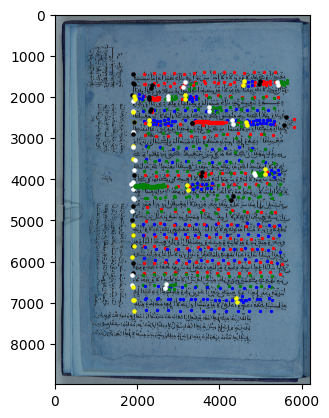

In [9]:
# Uncomment to verify
img = cv2.imread('/home/msaeed3/mehreen/datasets/RASM/Add MS 7474_0013.jpg')
plt.imshow(cv2.flip(img, 1))


with open('/home/msaeed3/mehreen/datasets/additional_sets/RASM/base_Add MS 7474_0013/base_Add MS 7474_0013.json') as fin:
    obj = json.load(fin)
for ind, o in enumerate(obj):
    
    col = ['red', 'green', 'blue'][ind%3]
    for c in o['lf']:
        plt.scatter([c['x0'],c['x1']], [c['y0'],c['y1']], color=col, s=2)
    start_color = ['black', 'white', 'yellow'][ind%3]
    plt.scatter([o['sol']['x0'], o['sol']['x1']], [o['sol']['y0'], o['sol']['y1']], s=5, color=start_color)            

# This is for priinting the json file in readable format

json_file = '/home/msaeed3/mehreen/datasets/arabic_all/Train.json'
with open(json_file, 'r') as fin:
    json_obj = json.load(fin)

out_file = '/home/msaeed3/mehreen/datasets/arabic_all/Train_readable.json'
with open(out_file, 'w') as fout:
    json.dump(json_obj, fout, indent=2)